<a href="https://colab.research.google.com/github/CristhianForero08/Monitoreo-de-Ranking-de-Palabras-Clave-Google/blob/main/Monitoreo_de_Ranking_de_Palabras_Clave_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Descubre la posición de tu URL en Google y optimiza tu estrategia SEO

## Descripción

El **Google Search Position Finder** es una herramienta diseñada para ayudar a las empresas a conocer el ranking de una URL específica en los resultados de búsqueda de Google para una consulta determinada. Esta aplicación extrae las 100 primeras URLs de los resultados de búsqueda, determina la posición de la URL objetivo y proporciona detalles sobre los títulos y las metadescripciones de estas URLs. Los resultados se pueden descargar en un archivo Excel para un análisis más detallado.

## Guía de Uso

1. **Ejecución**: Asegúrate de ejecutar las dos celdas que contiene el script principal (Ejecución del script) y la interfaz de usuario.

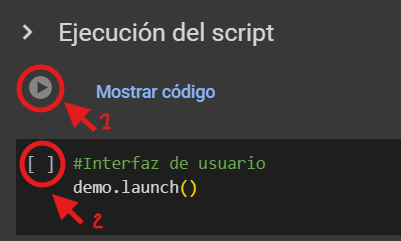

2. **Interfaz**:
    - **Consulta de búsqueda**: Campo para ingresar la consulta que quieres buscar en Google.(por ejemplo, "mejores prácticas SEO").
    - **URL objetivo**: Campo para ingresar la URL que quieres encontrar en los resultados.(por ejemplo, "https://www.ejemplo.com").
    - **Código del país**: Campo para ingresar el código del país que se utilizará en la búsqueda.(por ejemplo, "co" para Colombia).
    - **Código del idioma**: Campo para ingresar el código del idioma que se utilizará en la búsqueda.(por ejemplo, "en" para inglés 0 "es" para español).
    - **Dar click en botón *BUSCAR***
    - **Tiempo de ejecución aproximado 5 minutos **
    - **Resultados**: Muestra la posición de la URL objetivo y los detalles de las 100 primeras URLs.
    - **Descargar resultados**: Proporciona un enlace para descargar los resultados en formato Excel.


3. **Resultados**:
    - La aplicación mostrará la posición de la URL objetivo en los primeros 100 resultados de búsqueda y proporcionará un resumen de las URLs, títulos y metadescripciones.
    - Los resultados también se guardarán en un archivo Excel que puedes descargar para su análisis.

Utiliza esta herramienta para monitorear la visibilidad de tu sitio web en los resultados de búsqueda y optimizar tu estrategia SEO.


In [16]:
#@title Ejecución del script


%%capture



!pip install requests beautifulsoup4 gradio openpyxl

import requests
from bs4 import BeautifulSoup
import gradio as gr
import pandas as pd

def get_meta_description(url):
    try:
        response = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
        response.raise_for_status()
        soup = BeautifulSoup(response.text, 'html.parser')
        meta = soup.find('meta', attrs={'name': 'description'})
        if meta:
            return meta.get('content', 'No description')
        return 'No description'
    except Exception as e:
        return f'Error: {str(e)}'

def get_google_search_position_and_top_results(query, target_url, country_code, language_code, num_results=100):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }

    # URL encode the query
    query = query.replace(' ', '+')

    # Perform the Google search with country and language settings
    search_url = f'https://www.google.com/search?q={query}&num={num_results}&hl={language_code}&gl={country_code}'
    response = requests.get(search_url, headers=headers)
    response.raise_for_status()

    # Parse the search results page
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all search result links
    search_results = soup.find_all('div', {'class': 'g'})

    found_position = None
    top_results = []
    titles = []
    metadescriptions = []

    for index, result in enumerate(search_results):
        link = result.find('a', href=True)
        title = result.find('h3')

        if link:
            url = link['href']
            top_results.append(url)
            titles.append(title.text if title else 'No title')
            metadescription = get_meta_description(url)
            metadescriptions.append(metadescription)
            if target_url in url and found_position is None:
                found_position = index + 1

    return found_position, top_results[:100], titles[:100], metadescriptions[:100]

def search(query, target_url, country_code, language_code):
    position, top_results, titles, metadescriptions = get_google_search_position_and_top_results(query, target_url, country_code, language_code)

    # Prepare the output
    result_text = "\nLas 100 primeras URLs en los resultados de búsqueda son:\n"
    for i, (url, title, metadesc) in enumerate(zip(top_results, titles, metadescriptions), start=1):
        result_text += f"{i}. URL: {url}\n   Título: {title}\n   Metadescripción: {metadesc}\n"

    if position:
        result_text += f"\n*****La URL '{target_url}' está en la posición {position} para la consulta '{query}' en el país '{country_code}'.***"
    else:
        result_text += f"\n***La URL '{target_url}' no se encuentra entre los primeros 100 resultados para la consulta '{query}' en el país '{country_code}'.***"

    # Save results to Excel
    df = pd.DataFrame({
        'Rank': range(1, len(top_results)+1),
        'URL': top_results,
        'Title': titles,
        'Meta Description': metadescriptions
    })
    excel_path = f"/content/resultados: '{query}'.xlsx"
    df.to_excel(excel_path, index=False)

    return result_text, excel_path

# Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# Google Search Position Finder - Neogyck")
    query = gr.Textbox(label="Consulta de búsqueda", placeholder="Ingrese su consulta de búsqueda")
    target_url = gr.Textbox(label="URL objetivo", placeholder="Ingrese la URL para buscar en los resultados")

    country_code = gr.Dropdown(
        label="Código del país",
        choices=[("Colombia", "co"), ("México", "mx"), ("España", "es"), ("Estados Unidos", "us"), ("Argentina", "ar"), ("Chile", "cl"), ("Perú", "pe") ],
        value="co",
        type="value"
    )

    language_code = gr.Dropdown(
        label="Código del idioma",
        choices=[("Español", "es"), ("Inglés", "en")],
        value="es",
        type="value"
    )

    output = gr.Textbox(label="Resultados", interactive=False)
    file_output = gr.File(label="Descargar resultados")

    search_button = gr.Button("Buscar")

    def process_search(query, target_url, country_code, language_code):
        result_text, excel_path = search(query, target_url, country_code, language_code)
        return result_text, excel_path

    search_button.click(process_search, [query, target_url, country_code, language_code], [output, file_output])



#Descargo de Responsabilidad


#La aplicación "Google Search Position Finder - Neogyck" y su contenido son proporcionados "tal cual" y "según disponibilidad". Al utilizar esta aplicación, usted acepta los siguientes términos de descargo de responsabilidad:

#Uso Apropiado: La aplicación está diseñada para fines informativos y educativos. El uso inadecuado, ilegal o no autorizado de esta aplicación, incluyendo pero no limitado a la realización de scraping sin permiso o la violación de términos de servicio de terceros, es estrictamente prohibido.

#Responsabilidad del Usuario: Usted es el único responsable de cualquier uso que haga de la aplicación. Neogyck no se hace responsable de ningún daño, pérdida o consecuencia que pueda surgir del uso inapropiado o indebido de la aplicación, ni de la exactitud, veracidad o integridad de los resultados obtenidos.

#Conformidad Legal: Es su responsabilidad asegurarse de que el uso de la aplicación cumpla con todas las leyes y regulaciones aplicables en su jurisdicción. No nos hacemos responsables de cualquier acción legal que pueda resultar del uso de esta aplicación.

#Limitación de Responsabilidad: Neogyck no garantiza que la aplicación esté libre de errores o interrupciones y no se responsabiliza de ningún error o inexactitud en el funcionamiento de la misma. En ningún caso, Neogyck será responsable por daños directos, indirectos, incidentales, especiales o consecuentes, que surjan del uso o la imposibilidad de uso de la aplicación.

#Modificaciones: Neogyck se reserva el derecho de modificar, suspender o descontinuar la aplicación en cualquier momento sin previo aviso.

#Al utilizar esta aplicación, usted acepta estos términos y condiciones. Si no está de acuerdo con ellos, no utilice la aplicación.


In [17]:
#Interfaz de usuario
demo.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0276a49cee3cee435c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
